# Data Clustering from scratch - Density-Based Clustering - DBSCAN

In [9]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [12]:
def euclidean_distance(point1, point2):
    """
    Compute the Euclidean distance between two points.
    """
    return np.linalg.norm(point1 - point2)

def region_query(df, point_idx, eps):
    """
    Find all points within the eps radius of the given point.
    """
    neighbors = []
    for i in range(len(df)):
        if euclidean_distance(df[point_idx], df[i]) <= eps:
            neighbors.append(i)
    return neighbors

def expand_cluster(df, labels, point_idx, neighbors, cluster_id, eps, min_pts):
    """
    Expand the cluster by recursively adding neighboring points that are core points.
    """
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbors):
        neighbor_point_idx = neighbors[i]
        if labels[neighbor_point_idx] == -1:
            # Change label from noise to border point
            labels[neighbor_point_idx] = cluster_id
        elif labels[neighbor_point_idx] == 0:
            # If the point is not yet assigned to a cluster
            labels[neighbor_point_idx] = cluster_id
            new_neighbors = region_query(df, neighbor_point_idx, eps)
            if len(new_neighbors) >= min_pts:
                neighbors += new_neighbors
        i += 1

        
def dbscan(df, eps, min_pts):
    """
    DBSCAN clustering algorithm.
    Parameters:
    - df: Dataset as a numpy array
    - eps: The maximum distance between two samples for them to be considered as neighbors.
    - min_pts: The number of points in a neighborhood to form a dense region.
    
    Returns:
    - labels: An array of cluster assignments for each point (noise points are labeled as -1).
    """
    labels = [0] * len(df)  # Initialize all points as unvisited (label 0)
    cluster_id = 0
    
    for point_idx in range(len(df)):
        if labels[point_idx] != 0:  # Point already processed
            continue
        
        # Find neighbors of the current point
        neighbors = region_query(df, point_idx, eps)
        
        # If the point is not a core point (i.e., not enough neighbors)
        if len(neighbors) < min_pts:
            labels[point_idx] = -1  # Label as noise
        else:
            cluster_id += 1  # Create a new cluster
            expand_cluster(df, labels, point_idx, neighbors, cluster_id, eps, min_pts)
    
    return labels

Cluster Labels (0: noise):
-1    178
Name: count, dtype: int64


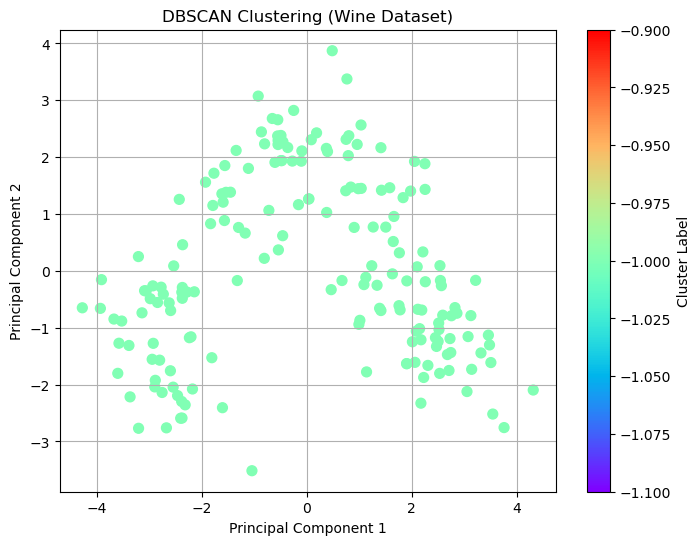

In [11]:
# Load the wine dataset
wine = load_wine()
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Apply DBSCAN
eps = 0.5  # Maximum distance for neighbors
min_pts = 5  # Minimum number of points to form a cluster
labels = dbscan(df_scaled, eps, min_pts)

# Add cluster labels to DataFrame
df['Cluster'] = labels

# Print cluster counts
print("Cluster Labels (0: noise):")
print(pd.Series(labels).value_counts())

# Visualization using PCA (reducing dimensionality to 2D)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Plot the DBSCAN clustering result
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='rainbow', marker='o', s=50)
plt.title('DBSCAN Clustering (Wine Dataset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()